# Random Forest Regressor
Neste notebook usamos o Random Forest Regressor para tentar prever a coluna 'price' (preço) do dataset de veículos do craiglist.

In [1]:
from Utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'
rcParams['lines.linewidth'] = 2.0

RANDOM_FOREST_REGRESSOR_EXPERIMENT = "RandomForestRegressor"

In [2]:
train_df = load_vehicles_dataset_and_set_types_2('../datasets/regressor/train_regressor_vehicles.csv')
train_df = set_categories_as_codes(train_df)
test_df = load_vehicles_dataset_and_set_types_2('../datasets/regressor/test_regressor_vehicles.csv')
test_df = set_categories_as_codes(test_df)

([<matplotlib.axis.XTick at 0x7fcff4352c10>,
 [Text(0, 0, 'year'),
  Text(1, 0, 'manufacturer'),
  Text(2, 0, 'fuel'),
  Text(3, 0, 'odometer'),
  Text(4, 0, 'title_status'),
  Text(5, 0, 'transmission'),
  Text(6, 0, 'drive'),
  Text(7, 0, 'type'),
  Text(8, 0, 'state'),
  Text(9, 0, 'price')])

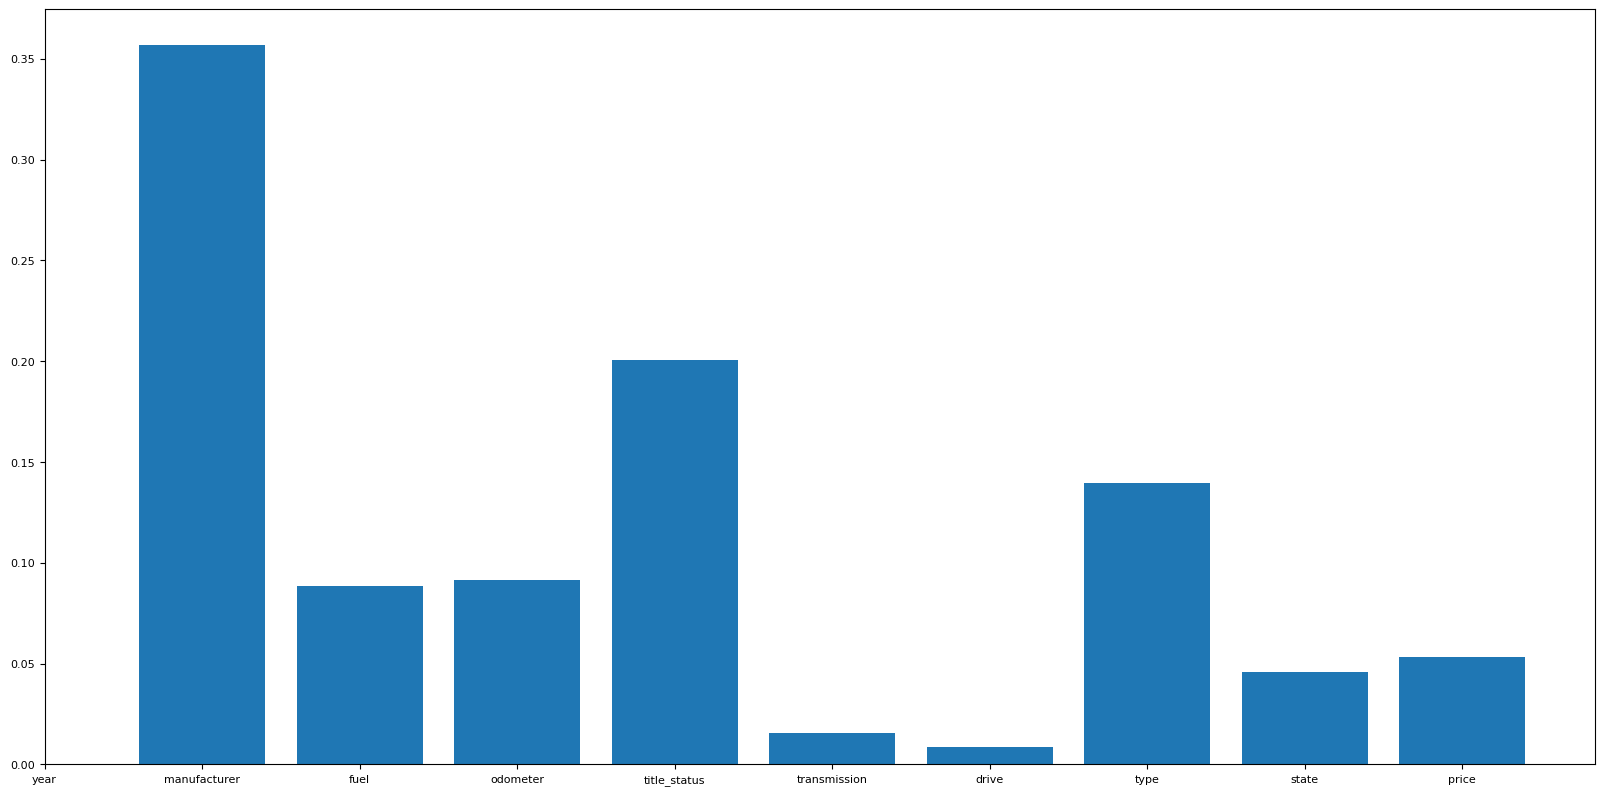

In [8]:
regr = RandomForestRegressor()
#regr.fit(train_df.drop(columns=['price']).values, train_df[['price']].values.reshape(train_df[['price']].shape[0],))
regr.fit(train_df.drop(columns=['price']), train_df['price'])
plt.bar(np.arange(1, 10), regr.feature_importances_)
plt.xticks(np.arange(0, 10), train_df.columns)

## Prevendo dataset de treino e de teste
Aqui também é feito o tracking usando o MLflow

In [6]:
params = {'n_estimators': 100, 'max_depth': None, 'max_features': 'auto'}
model = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], max_features=params['max_features'])
run_regressor_and_track(train_df, 'train_regressor_vehicles.csv', test_df, 'test_regressor_vehicles.csv', model, RANDOM_FOREST_REGRESSOR_EXPERIMENT, 'price', "RandomForestRegressor", params)

train_R2: 0.9764
train_MSE: 2497723.4033
train_MAE: 883.1920

test_R2: 0.8237
test_MSE: 18580282.4900
test_MAE: 2367.8127



## Otimizando hiperparâmetros
Vamos usar o optuna para otimizar os parâmetros:
- n_estimators
- max_depth
- max_features

In [3]:
import optuna
import sklearn.model_selection

In [4]:
def objective(trial):
    validation_df = load_vehicles_dataset_and_set_types_2('../datasets/regressor/validation_regressor_vehicles.csv')
    validation_df = set_categories_as_codes(validation_df)
    
    x_df = validation_df.drop(columns=['price'])
    target = validation_df['price']
    
    classifier_name = trial.suggest_categorical('classifier', ['RandomForestRegressor'])
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, step=10)
    max_depth = trial.suggest_int('max_depth', 10, 110, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    regressor.fit(x_df, target)
    predict = regressor.predict(x_df)

    metrics = eval_regressor_metrics(target, predict, False)
    r2 = metrics['test_r2']
    return r2

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2020-11-17 01:49:33,023] A new study created in memory with name: no-name-d3513845-ffa1-43a4-a67b-77f47dd9fbda
[I 2020-11-17 01:50:41,426] Trial 0 finished with value: 0.9686171166823763 and parameters: {'classifier': 'RandomForestRegressor', 'n_estimators': 350, 'max_depth': 52, 'max_features': 'auto'}. Best is trial 0 with value: 0.9686171166823763.
[I 2020-11-17 01:51:21,548] Trial 1 finished with value: 0.9683654239846594 and parameters: {'classifier': 'RandomForestRegressor', 'n_estimators': 200, 'max_depth': 61, 'max_features': 'auto'}. Best is trial 0 with value: 0.9686171166823763.
[I 2020-11-17 01:52:50,097] Trial 2 finished with value: 0.9688079643286063 and parameters: {'classifier': 'RandomForestRegressor', 'n_estimators': 460, 'max_depth': 70, 'max_features': 'auto'}. Best is trial 2 with value: 0.9688079643286063.
[I 2020-11-17 01:53:40,651] Trial 3 finished with value: 0.9706463588684318 and parameters: {'classifier': 'RandomForestRegressor', 'n_estimators': 520, 'max

FrozenTrial(number=85, value=0.970908172836421, datetime_start=datetime.datetime(2020, 11, 17, 3, 40, 22, 563512), datetime_complete=datetime.datetime(2020, 11, 17, 3, 41, 38, 848037), params={'classifier': 'RandomForestRegressor', 'n_estimators': 800, 'max_depth': 88, 'max_features': 'sqrt'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForestRegressor',)), 'n_estimators': IntUniformDistribution(high=1000, low=10, step=10), 'max_depth': IntUniformDistribution(high=110, low=10, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=85, state=TrialState.COMPLETE)


Os melhores valores dos hiperaparâmetros encontrados são:
- n_estimators = 800
- max_depth = 88
- max_features = sqrt
  
Utilizando esses valores para o RandomForestRegressor


In [5]:
params = {'n_estimators': 800, 'max_depth': 88, 'max_features': 'sqrt'}
model = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], max_features=params['max_features'])
run_regressor_and_track(train_df, 'train_regressor_vehicles.csv', test_df, 'test_regressor_vehicles.csv', model, RANDOM_FOREST_REGRESSOR_EXPERIMENT, 'price', "RandomForestRegressorWithTunning", params)

train_R2: 0.9783
train_MSE: 2297081.6501
train_MAE: 856.1436

test_R2: 0.8322
test_MSE: 17691107.8598
test_MAE: 2312.6929



Houve uma melhora sutil nos resultados:
- train_R2: 0.9764 -> 0.9783
- test_R2: 0.8237 -> 0.8322

Esses resultados podem ser comparados na UI do MLflow.

## Diagnóstico do Modelo
Esse é o nosso modelo escolhido, ele obteve melhores resultados em relação aos demais:


Considerando um alvo de 5% de erro, o modelo apresentou:

In [6]:
bias, variance = eval_bia_and_variance(97.83, 83.22, 5)

print("Viés: {:.2f}\nVariância: {:.2f}".format(bias, variance))

Viés: 2.83
Variância: 14.61


Com isso confirmamos que o modelo está em situação de Overfitting, podemos usar as seguintes estratégias para resolver o overfitting:

- Reduzir a complexidade do modelo
- Feature Selection
- Adicionar dados ao conjunto de treinamento